**Packages**

In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
import tifffile

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import os

import scipy

2023-03-15 07:11:18.336738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 07:11:18.486039: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-15 07:11:18.486064: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-15 07:11:19.278871: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

**Helper Functions**

In [2]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
   # plt.plot(history.history['accuracy'], label='accuracy')
   # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['loss']),
                max(history.history['val_loss'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)

In [3]:
def plot_accuracy(history):
   # plt.plot(history.history['loss'], label='loss')
   # plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['accuracy']),
                max(history.history['val_accuracy'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)

In [4]:
# FROM https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py

kaiming_normal = keras.initializers.VarianceScaling(scale=2.0, mode='fan_out', distribution='untruncated_normal')

def conv3x3(x, out_planes, stride=1, name=None):
    x = layers.ZeroPadding2D(padding=1, name=f'{name}_pad')(x)
    return layers.Conv2D(filters=out_planes, kernel_size=3, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=name)(x)

def basic_block(x, planes, stride=1, downsample=None, name=None):
    identity = x

    out = conv3x3(x, planes, stride=stride, name=f'{name}.conv1')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn1')(out)
    out = layers.ReLU(name=f'{name}.relu1')(out)

    out = conv3x3(out, planes, name=f'{name}.conv2')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn2')(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)

    out = layers.Add(name=f'{name}.add')([identity, out])
    out = layers.ReLU(name=f'{name}.relu2')(out)

    return out

def make_layer(x, planes, blocks, stride=1, name=None):
    downsample = None
    inplanes = x.shape[3]
    if stride != 1 or inplanes != planes:
        downsample = [
            layers.Conv2D(filters=planes, kernel_size=1, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=f'{name}.0.downsample.0'),
            layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.0.downsample.1'),
        ]

    x = basic_block(x, planes, stride, downsample, name=f'{name}.0')
    for i in range(1, blocks):
        x = basic_block(x, planes, name=f'{name}.{i}')

    return x

def resnet(x, blocks_per_layer, num_classes=1000):
    x = layers.ZeroPadding2D(padding=3, name='conv1_pad')(x)
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, kernel_initializer=kaiming_normal, name='conv1')(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='bn1')(x)
    x = layers.ReLU(name='relu1')(x)
    x = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)

    x = make_layer(x, 64, blocks_per_layer[0], name='layer1')
    x = make_layer(x, 128, blocks_per_layer[1], stride=2, name='layer2')
    x = make_layer(x, 256, blocks_per_layer[2], stride=2, name='layer3')
    x = make_layer(x, 512, blocks_per_layer[3], stride=2, name='layer4')

    x = layers.GlobalAveragePooling2D(name='avgpool')(x)
    initializer = keras.initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512))
    x = layers.Dense(units=num_classes, kernel_initializer=initializer, bias_initializer=initializer, name='fc')(x)

    return x

def resnet18(x, **kwargs):
    return resnet(x, [2, 2, 2, 2], **kwargs)

def resnet34(x, **kwargs):
    return resnet(x, [3, 4, 6, 3], **kwargs)

**Data Pre-Processing**

In [5]:
tiles = pd.read_csv(r'./Data/Tiles_binned.csv')
tiles.head(5)

,Tile_ID,Long2,Lat2,Long1,Lat1,Mid_lat,Mid_long,Stop_Signs,Paving_historical,Paving_future,Bus_stop,Collisions_Future,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,bin
0,36,-122.514446,37.779636,-122.513306,37.778732,37.779184,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
1,37,-122.514446,37.778732,-122.513306,37.777829,37.778280,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
2,151,-122.513306,37.779636,-122.512166,37.778732,37.779184,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
3,152,-122.513306,37.778732,-122.512166,37.777829,37.778280,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
4,153,-122.513306,37.777829,-122.512166,37.776925,37.777377,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0


Split into training and test

In [6]:
x_train, x_test, y_train, y_test = train_test_split(tiles[['Tile_ID','Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U']], 
                                   tiles['bin'],
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)

Image Pre-Processing

In [7]:
IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [8]:
images_mini = preprocess_data_part1(IMAGE_PATH)
np.shape(images_mini)

(8376, 148, 188, 4)

In [9]:
IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part2(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_test['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [10]:
images_mini_t = preprocess_data_part2(IMAGE_PATH)
np.shape(images_mini_t)

(2095, 148, 188, 4)

Street Data Pre-Processing

In [11]:
street = np.asarray(x_train[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U']]).astype('float32')
street_mini = []
for row in range(len(street)):
    street_mini.append([[street[row]]])
street_mini = np.stack(street_mini)
np.shape(street_mini)

(8376, 1, 1, 11)

In [13]:
street_t = np.asarray(x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U']]).astype('float32')
street_mini_t = []
for row in range(len(street_t)):
    street_mini_t.append([[street_t[row]]])
street_mini_t = np.stack(street_mini_t)
np.shape(street_mini_t)

(2095, 1, 1, 11)

**Modeling**

Helpful Links: <br>
https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/ <br>
https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50 <br>
https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py <BR>

**Model 2.1: CNN (layers added, ResNet-18)**

In [12]:
# x: Satellite Images, 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop'
# y: 'Collisions_Future'

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,11), name='Input_Street')
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(11, (4,4), activation="relu")(input1)
    pooling = tf.keras.layers.MaxPooling2D((4, 4), strides=2)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    output = tf.keras.layers.Dense(units=12, activation='softmax', name='output')(resnet)
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics = ['accuracy']
    )

class_weight = {0: 100,
                1: 1000,
                2: 1000,
                3: 1000,
                4: 1000,
                5: 1000,
                6: 1000,
                7: 1000,
                8: 1000,
                9: 1000,
                10: 1000,
                11: 1000,
               }

history = cnn_model.fit(
    [images_mini, street_mini],
    np.stack(y_train),
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    class_weight = class_weight
    )

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 145, 185, 11  715         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 71, 91, 11)  0           ['conv2d_1[0][0]']               
                                                                                            

2023-03-14 04:19:17.724664: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2982732800 exceeds 10% of free system memory.


Epoch 1/10
210/210 [==============================] - ETA: 0s - loss: 503.4752 - accuracy: 0.3893

2023-03-14 04:21:18.509526: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 746128384 exceeds 10% of free system memory.


210/210 [==============================] - 122s 551ms/step - loss: 503.4752 - accuracy: 0.3893 - val_loss: 0.7580 - val_accuracy: 0.7220
Epoch 2/10
210/210 [==============================] - 114s 541ms/step - loss: 351.3838 - accuracy: 0.4543 - val_loss: 1.1819 - val_accuracy: 0.8109
Epoch 3/10
210/210 [==============================] - 112s 533ms/step - loss: 328.3952 - accuracy: 0.5242 - val_loss: 1.7505 - val_accuracy: 0.1307
Epoch 4/10
210/210 [==============================] - 112s 533ms/step - loss: 314.2674 - accuracy: 0.5357 - val_loss: 2.0199 - val_accuracy: 0.1766
Epoch 5/10
210/210 [==============================] - 111s 530ms/step - loss: 312.3137 - accuracy: 0.5342 - val_loss: 0.6016 - val_accuracy: 0.7619
Epoch 6/10
210/210 [==============================] - 111s 528ms/step - loss: 307.4365 - accuracy: 0.5512 - val_loss: 0.6228 - val_accuracy: 0.8103
Epoch 7/10
210/210 [==============================] - 111s 527ms/step - loss: 300.4453 - accuracy: 0.5548 - val_loss: 1.050

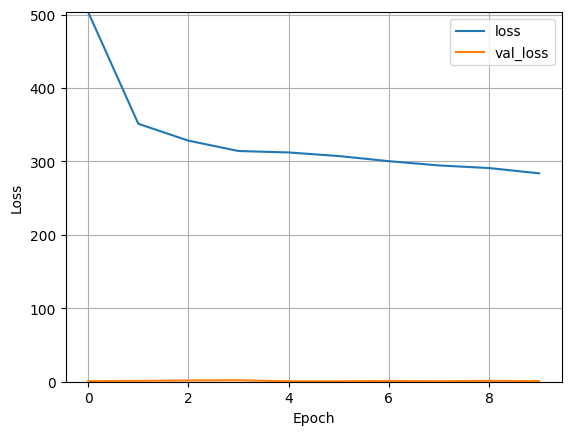

In [24]:
plot_loss(history)

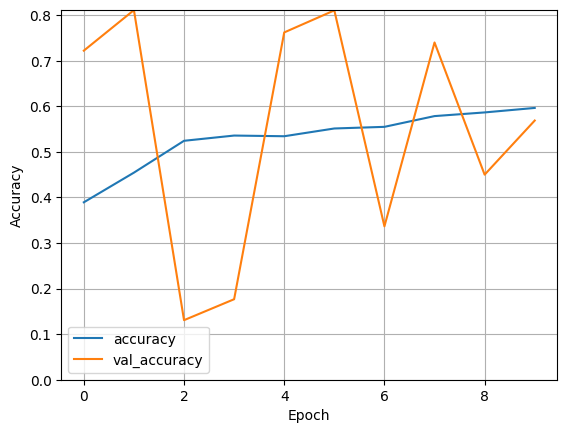

In [25]:
plot_accuracy(history)

In [ ]:
predicted_result = cnn_model.predict([images_mini_t, street_mini_t])
test_values = []
for i in predicted_result: 
    input_list = i
    max_value = max(input_list)
    index = [index for index, item in enumerate(input_list) if item == max_value]
    test_values.append(index[0])
print('macro f1: ', f1_score(y_test, test_values, average = 'macro' ))
print('f1 by class: ', f1_score(y_test, test_values, average = None ))

**Model 2.2: Second CNN (layers added, ResNet-34)**

In [14]:
# x: Satellite Images, 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop'
# y: 'Collisions_Future'

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,11), name='Input_Street')
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(11, (4,4), activation="relu")(input1)
    pooling = tf.keras.layers.MaxPooling2D((4, 4), strides=2)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet34(combined)
    output = tf.keras.layers.Dense(units=12, activation='softmax', name='output')(resnet)
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics = ['accuracy']
    )

class_weight = {0: 100,
                1: 1000,
                2: 1000,
                3: 1000,
                4: 1000,
                5: 1000,
                6: 1000,
                7: 1000,
                8: 1000,
                9: 1000,
                10: 1000,
                11: 1000,
               }

history = cnn_model.fit(
    [images_mini, street_mini],
    np.stack(y_train),
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    class_weight = class_weight, 
    )


2023-03-15 07:18:33.865741: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-15 07:18:33.865775: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-15 07:18:33.865798: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-82-179): /proc/driver/nvidia/version does not exist
2023-03-15 07:18:33.866006: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initialize

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 145, 185, 11  715         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 71, 91, 11)   0           ['conv2d[0][0]']                 
                                                                                            

/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


 layer3.1.relu1 (ReLU)          (None, 5, 6, 256)    0           ['layer3.1.bn1[0][0]']           
                                                                                                  
 layer3.1.conv2_pad (ZeroPaddin  (None, 7, 8, 256)   0           ['layer3.1.relu1[0][0]']         
 g2D)                                                                                             
                                                                                                  
 layer3.1.conv2 (Conv2D)        (None, 5, 6, 256)    589824      ['layer3.1.conv2_pad[0][0]']     
                                                                                                  
 layer3.1.bn2 (BatchNormalizati  (None, 5, 6, 256)   1024        ['layer3.1.conv2[0][0]']         
 on)                                                                                              
                                                                                                  
 layer3.1.

2023-03-15 07:18:35.282393: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2982732800 exceeds 10% of free system memory.


210/210 [==============================] - 204s 921ms/step - loss: 534.1429 - accuracy: 0.3113 - val_loss: 0.8911 - val_accuracy: 0.6247
Epoch 2/10
210/210 [==============================] - 183s 872ms/step - loss: 363.4720 - accuracy: 0.4385 - val_loss: 2.5263 - val_accuracy: 0.1301
Epoch 3/10
210/210 [==============================] - 187s 892ms/step - loss: 331.5182 - accuracy: 0.4963 - val_loss: 1.5140 - val_accuracy: 0.3204
Epoch 4/10
210/210 [==============================] - 186s 885ms/step - loss: 313.9374 - accuracy: 0.5509 - val_loss: 0.8761 - val_accuracy: 0.5889
Epoch 5/10
210/210 [==============================] - 182s 865ms/step - loss: 308.5118 - accuracy: 0.5660 - val_loss: 0.9222 - val_accuracy: 0.5710
Epoch 6/10
210/210 [==============================] - 184s 879ms/step - loss: 308.4844 - accuracy: 0.5713 - val_loss: 1.4053 - val_accuracy: 0.2369
Epoch 7/10
210/210 [==============================] - 183s 873ms/step - loss: 296.3803 - accuracy: 0.5912 - val_loss: 0.639

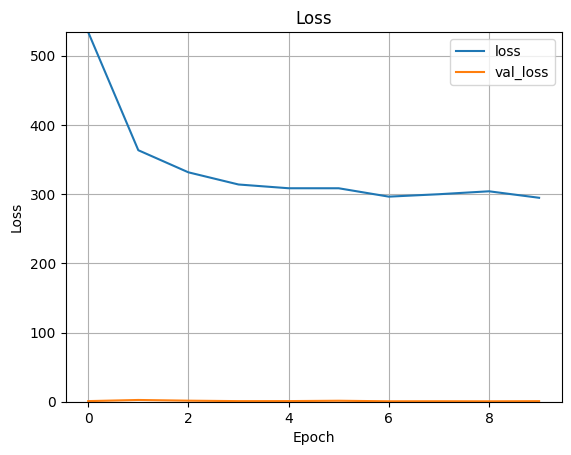

In [15]:
plot_loss(history)

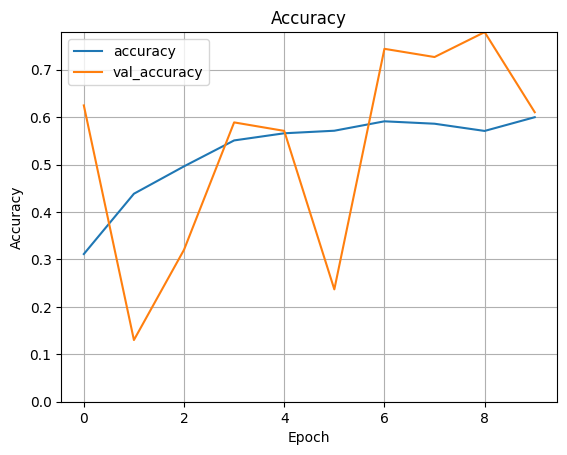

In [16]:
plot_accuracy(history)

In [17]:
predicted_result = cnn_model.predict([images_mini_t, street_mini_t])
predicted_result[0]

66/66 [==============================] - 9s 125ms/step


array([4.3911213e-01, 4.7623244e-01, 6.7027435e-02, 1.3805964e-02,
       1.8149718e-03, 1.0055189e-03, 3.3123448e-04, 3.7394903e-04,
       1.5999170e-04, 5.5509143e-05, 4.1007079e-05, 3.9853556e-05],
      dtype=float32)

In [19]:
test_values = []
for i in predicted_result: 
    input_list = i
    max_value = max(input_list)
    index = [index for index, item in enumerate(input_list) if item == max_value]
    test_values.append(index[0])
test_values[0:10]

[1, 1, 0, 0, 1, 0, 1, 0, 1, 1]

In [22]:
print('macro f1: ', f1_score(y_test, test_values, average = 'macro' ))
print('f1 by class: ', f1_score(y_test, test_values, average = None ))

macro f1:  0.12456635349204712
f1 by class:  [0.76489707 0.38985737 0.         0.         0.09090909 0.
 0.         0.         0.         0.        ]


**Model 2.3: CNN (layers concatenated, ResNet-18)**

In [39]:
street_mini_2 = [] 
for k in range(len(street)):
    for i in range(71): 
        for j in range(91):
            street_mini_2.append(street[k])

In [40]:
street_mini_2 = np.reshape(street_mini_2, (len(street),71,91,11))
np.shape(street_mini_2)

(8376, 71, 91, 11)

In [41]:
# x: Satellite Images, 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop'
# y: 'Collisions_Future'

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(71,91,11), name='Input_Street')
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(11, (4,4), activation="relu")(input1)
    pooling = tf.keras.layers.MaxPooling2D((4, 4), strides=2)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    combined = tf.keras.layers.Concatenate(axis = 3)([images.output, input2])
    #combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    output = tf.keras.layers.Dense(units=12, activation='softmax', name='output')(resnet)
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics = ['accuracy']
    )

class_weight = {0: 100,
                1: 1000,
                2: 1000,
                3: 1000,
                4: 1000,
                5: 1000,
                6: 1000,
                7: 1000,
                8: 1000,
                9: 1000,
                10: 1000,
                11: 1000,
               }

history = cnn_model.fit(
    [images_mini, street_mini_2],
    np.stack(y_train),
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    class_weight = class_weight,
    )

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 145, 185, 11  715         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 71, 91, 11)  0           ['conv2d_4[0][0]']               
                                                                                            

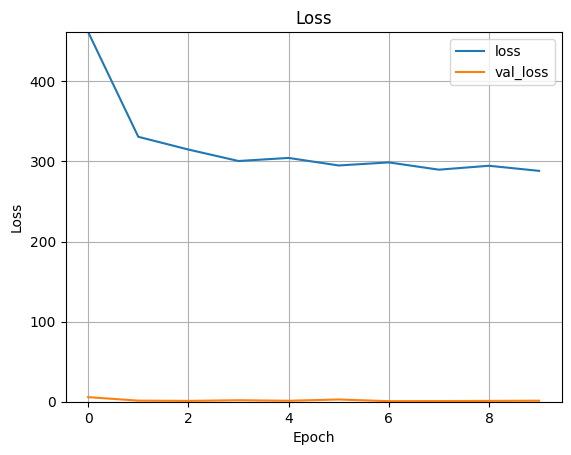

In [42]:
plot_loss(history)

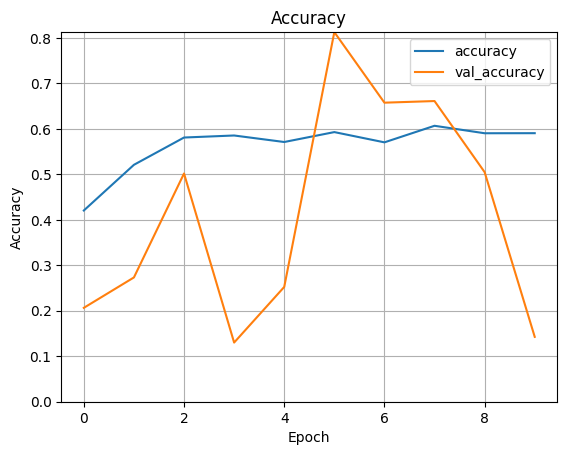

In [43]:
plot_accuracy(history)

In [ ]:
predicted_result = cnn_model.predict([images_mini_t, street_mini_t])
test_values = []
for i in predicted_result: 
    input_list = i
    max_value = max(input_list)
    index = [index for index, item in enumerate(input_list) if item == max_value]
    test_values.append(index[0])
print('macro f1: ', f1_score(y_test, test_values, average = 'macro' ))
print('f1 by class: ', f1_score(y_test, test_values, average = None ))

**Model 2.4 CNN (layers added, RESNET 50 FROM TENSORFLOW)**

In [25]:
images_mini.shape

(8376, 148, 188, 4)

In [26]:
street_mini.shape

(8376, 1, 1, 11)

In [27]:
y_train.shape

(8376,)

In [28]:
y_train[0]

0

In [29]:
# x: Satellite Images, 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop'
# y: 'Collisions_Future'

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,11), name='Input_Street')
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(11, (4,4), activation="relu")(input1)
    pooling = tf.keras.layers.MaxPooling2D((4, 4), strides=2)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    # RESNET50 FROM TENSORFLOW 
    resnet = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights=None,
    input_tensor=combined,
    input_shape=(71, 91, 11,),
    pooling=None,
    classes=12,
    #**kwargs
    )
    
    flatten = tf.keras.layers.Flatten()(resnet.output)
    
    output = tf.keras.layers.Dense(units=12, activation='softmax', name='output')(flatten)
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model #cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= ['sparse_categorical_crossentropy'],
    metrics = ['accuracy'],
    )

class_weight = {0: 100,
                1: 1000,
                2: 1000,
                3: 1000,
                4: 1000,
                5: 1000,
                6: 1000,
                7: 1000,
                8: 1000,
                9: 1000,
                10: 1000,
                11: 1000,
               }

history = cnn_model.fit(
    [images_mini, street_mini],
    np.stack(y_train),
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    class_weight = class_weight,
    )

/home/ubuntu/capstone/lib/python3.10/site-packages/keras/applications/resnet.py:159: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 11 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 145, 185, 11  715         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 71, 91, 11)  0           ['conv2d_5[0][0]']               
                                                                                           

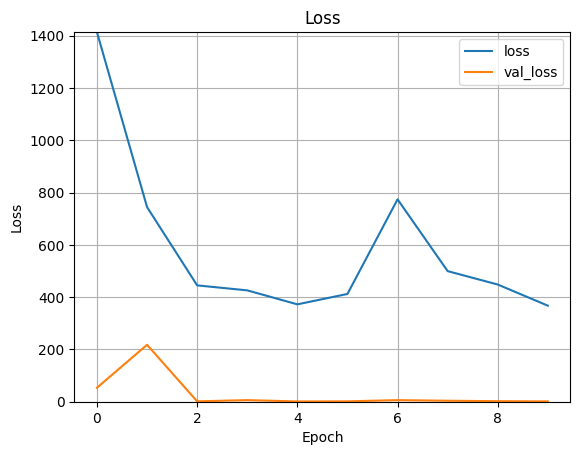

In [30]:
plot_loss(history)

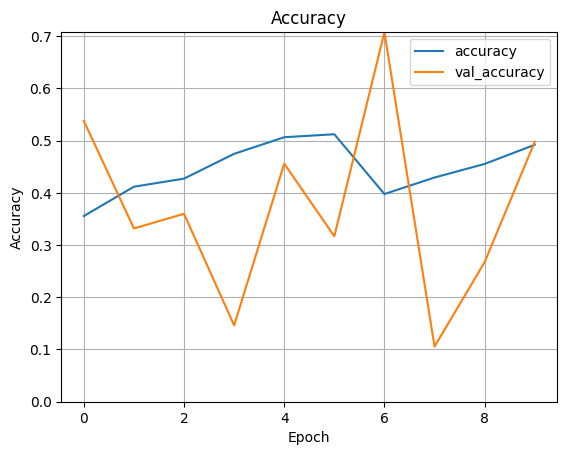

In [31]:
plot_accuracy(history)

In [ ]:
predicted_result = cnn_model.predict([images_mini_t, street_mini_t])
test_values = []
for i in predicted_result: 
    input_list = i
    max_value = max(input_list)
    index = [index for index, item in enumerate(input_list) if item == max_value]
    test_values.append(index[0])
print('macro f1: ', f1_score(y_test, test_values, average = 'macro' ))
print('f1 by class: ', f1_score(y_test, test_values, average = None ))